# All data

In [14]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multiimage_reasoning/multi-image/lmms-eval/logs/masked"
BASELINE_LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multiimage_reasoning/multi-image/lmms-eval/logs/baseline"
# ==========================================
# 2. DATA EXTRACTION
# ==========================================

def get_primary_score(metrics):
    """Finds the first float value that isn't stderr/alias."""
    for key, val in metrics.items():
        if isinstance(val, (int, float)) and "stderr" not in key and "alias" not in key:
            return val * 100
    return None

all_rows = []

# Iterate through directories
# Find all JSON results recursively
search_pattern = os.path.join(LOG_DIRECTORIES, "**", "*_results.json")
files = glob.glob(search_pattern, recursive=True)

for file_path in files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except:
        continue

    # 1. Identify Model
    model_name = data.get('model_name_sanitized', data.get('model_name', 'Unknown'))
    model_name = model_name.split("__")[1]
    # The layer is the part after -mask-attention- 
    layer = file_path.split("/")[-3].split("-mask-")[-1]
    row = {
        'Model': model_name,
        'Masked Layers': layer
    }

    # 2. Extract Scores
    results = data.get('results', {})
    
    for task, metrics in results.items():
        score = get_primary_score(metrics)
        
        if score is None: continue

        # Map to readable column names
        if task == 'blink':
            row['BLINK'] = score
        elif task == 'mirb':
            row['MIRB'] = score
        elif task == 'muirbench':
            row['MuirBench'] = score
        elif task.startswith('blink_'):
            # Clean subtask name: blink_art_style -> Art Style
            clean_name = task.replace('blink_', '').replace('_', ' ').title()
            row[clean_name] = score
    
    if len(row) > 2: # Only add if we found some metrics
        all_rows.append(row)
        
# Extract the results from the baseline logs and aggregate them
search_pattern = os.path.join(BASELINE_LOG_DIRECTORIES, "**", "*_results.json")
files = glob.glob(search_pattern, recursive=True)

for file_path in files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except:
        continue
    model_name = data.get('model_name_sanitized', data.get('model_name', 'Unknown'))
    model_name = model_name.split("__")[1]
    row = {
        'Model': model_name,
        'Masked Layers': "baseline"
    }
    results = data.get('results', {})
    
    for task, metrics in results.items():
        score = get_primary_score(metrics)
        
        if score is None: continue

        # Map to readable column names
        if task == 'blink':
            row['BLINK'] = score
        elif task == 'mirb':
            row['MIRB'] = score
        elif task == 'muirbench':
            row['MuirBench'] = score
        elif task.startswith('blink_'):
            # Clean subtask name: blink_art_style -> Art Style
            clean_name = task.replace('blink_', '').replace('_', ' ').title()
            row[clean_name] = score
    
    if len(row) > 2: # Only add if we found some metrics
        all_rows.append(row)
# delete empty rows which have no results
all_rows = [row for row in all_rows if row]
# ==========================================
# 3. DATAFRAME CREATION
# ==========================================

if all_rows:
    df = pd.DataFrame(all_rows)
    
    # Sort by Model first (versions together), then Experiment
    df = df.sort_values(by=['Model', 'Masked Layers']).reset_index(drop=True)
    # Reorder the DataFrame so that 'Baseline' and 'all' rows come first,
    # followed by individual mask layers (single numbers), then grouped ranges.

    # Helper function to create a sorting key for 'Masked Layers'
    import re

    def masked_layer_sort_key(x):
        # Put 'baseline' and 'all' at the very top
        x_lower = str(x).lower()
        if x_lower == 'baseline' or x_lower == 'all':
            return (0, 0, 0)
        # Individual layer: just a single integer (e.g. '0', '5')
        if re.fullmatch(r'\d+', str(x)):
            return (1, int(x), 0)
        # Grouped range: e.g. '0-3', '4-7'
        m = re.fullmatch(r'(\d+)\-(\d+)', str(x))
        if m:
            return (2, int(m.group(1)), int(m.group(2)))
        # Other: put at end
        return (3, 0, 0)

    df = df.copy()
    df['__ml_sortkey'] = df['Masked Layers'].map(masked_layer_sort_key)
    df = df.sort_values(by=['Model', '__ml_sortkey']).reset_index(drop=True)
    df = df.drop(columns="__ml_sortkey")
    
    
    

    # --- TABLE 1: MAIN BENCHMARKS ---
    main_benchmarks = ['BLINK', 'MIRB', 'MuirBench']
    
    # Filter columns that actually exist in the data
    valid_main_cols = [c for c in main_benchmarks if c in df.columns]
    
    if valid_main_cols:
        # Create Main DataFrame
        df_main = df[['Model', 'Masked Layers'] + valid_main_cols].copy()
        
        print("\n### 1. Main Benchmark Results")
        # Apply 'Blues' colormap: Darker = Higher Value
        display(
            df_main.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=valid_main_cols)
            .set_properties(**{'text-align': 'center'})
        )

    # --- TABLE 2: BLINK SUBTASKS ---
    # Identify subtask columns (cols not in main benchmarks and not metadata)
    meta_cols = ['Model', 'Masked Layers']
    subtask_cols = [c for c in df.columns if c not in main_benchmarks and c not in meta_cols]
    subtask_cols.sort()
    
    if subtask_cols:
        # Create Subtask DataFrame
        df_blink = df[meta_cols + subtask_cols].copy()
        
        print("\n### 2. BLINK Subtask Breakdown")
        # You can keep this one different (e.g., Greens) or same (Blues)
        display(
            df_blink.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=subtask_cols)
            .set_properties(**{'text-align': 'center'})
        )

else:
    print("No data found.")


### 1. Main Benchmark Results


,Model,Masked Layers,BLINK,MIRB,MuirBench
0,InternVL3-1B,baseline,39.9,39.2,30.4
1,InternVL3-8B,baseline,54.1,53.9,52.7
2,InternVL3_5-1B,all,40.1,31.3,30.9
3,InternVL3_5-1B,baseline,40.0,37.8,36.2
4,InternVL3_5-1B,0,41.9,37.6,35.5
5,InternVL3_5-1B,0,41.9,37.6,35.5
6,InternVL3_5-1B,1,42.8,37.7,35.2
7,InternVL3_5-1B,1,42.8,37.7,35.2
8,InternVL3_5-1B,2,41.1,37.8,35.0
9,InternVL3_5-1B,2,41.1,37.8,35.0



### 2. BLINK Subtask Breakdown


,Model,Masked Layers,Art Style,Counting,Forensic Detection,Functional Correspondence,Iq Test,Jigsaw,Multi View Reasoning,Object Localization,Relative Depth,Relative Reflectance,Semantic Correspondence,Spatial Relation,Visual Correspondence,Visual Similarity
0,InternVL3-1B,baseline,47.0,49.2,15.9,20.0,20.0,52.7,45.1,48.4,61.3,25.4,30.2,65.0,26.7,51.1
1,InternVL3-8B,baseline,62.4,72.5,28.8,23.8,25.3,75.3,44.4,54.1,79.8,40.3,29.5,85.3,45.9,89.6
2,InternVL3_5-1B,all,44.4,52.5,10.6,23.8,11.3,52.0,44.4,55.7,65.3,36.6,22.3,71.3,23.8,47.4
3,InternVL3_5-1B,baseline,48.7,50.0,12.1,23.1,11.3,57.3,44.4,55.7,63.7,31.3,23.7,73.4,29.1,36.3
4,InternVL3_5-1B,0,54.7,52.5,11.4,19.2,11.3,62.7,44.4,55.7,65.3,36.6,21.6,71.3,22.7,57.0
5,InternVL3_5-1B,0,54.7,52.5,11.4,19.2,11.3,62.7,44.4,55.7,65.3,36.6,21.6,71.3,22.7,57.0
6,InternVL3_5-1B,1,50.4,52.5,12.9,23.1,11.3,66.0,44.4,55.7,65.3,36.6,28.8,71.3,25.0,55.6
7,InternVL3_5-1B,1,50.4,52.5,12.9,23.1,11.3,66.0,44.4,55.7,65.3,36.6,28.8,71.3,25.0,55.6
8,InternVL3_5-1B,2,46.2,52.5,11.4,23.1,11.3,64.0,44.4,55.7,65.3,36.6,20.9,71.3,16.9,55.6
9,InternVL3_5-1B,2,46.2,52.5,11.4,23.1,11.3,64.0,44.4,55.7,65.3,36.6,20.9,71.3,16.9,55.6


# Muirbench

In [7]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multi-image/lmms-eval/logs/masked"
BASELINE_LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multi-image/lmms-eval/logs/baseline"

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def normalize_val(val):
    """Normalizes answers (e.g., '4.0' -> '4', 'Yes' -> 'yes')."""
    s = str(val).strip().lower()
    try:
        f_val = float(s)
        if f_val.is_integer():
            return str(int(f_val))
    except:
        pass
    return s

def calculate_acc(correct, total):
    return (correct / total * 100) if total > 0 else 0.0

def parse_muirbench(file_path):
    stats = {} 
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('muirbench_score_overall', {})
                if not info: continue
                
                task = info.get('task', 'Unknown')
                pred = normalize_val(info.get('pred', ''))
                ans  = normalize_val(info.get('answer', ''))
                
                is_correct = (pred == ans)
                
                # Update Subtask Stats
                if task not in stats: stats[task] = {'c': 0, 't': 0}
                stats[task]['t'] += 1
                if is_correct: stats[task]['c'] += 1
                
                # Update Overall Stats
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        return None
        
    # Build Result Dict (Now including counts for weighting!)
    results = {}
    for k, v in stats.items():
        results[k] = calculate_acc(v['c'], v['t'])
        results[f"{k}_count"] = v['t'] # Save the total questions for this task
        
    results['Overall'] = calculate_acc(total_correct, total_count)
    return results


# ==========================================
# 3. MAIN EXECUTION
# ==========================================

muir_rows = []

results_files = glob.glob(os.path.join(LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)

for res_file in results_files:
    dir_name = os.path.dirname(res_file)
    base_name = os.path.basename(res_file).replace('_results.json', '')
    
    try:
        with open(res_file, 'r') as f:
            meta = json.load(f)
            model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
    except:
        continue
        
    # MuirBench
    muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
    layer = muir_path.split("/")[-3].split("-mask-")[-1]
    if os.path.exists(muir_path):
        scores = parse_muirbench(muir_path)
        if scores:
            row = {'Model': model_name, 'Masked Layers': layer}
            row.update(scores)
            muir_rows.append(row)
            
# Baseline 
baseline_files = glob.glob(os.path.join(BASELINE_LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)
for file_path in baseline_files:
    dir_name = os.path.dirname(file_path)
    base_name = os.path.basename(file_path).replace('_results.json', '')
    try:
        with open(file_path, 'r') as f:
            meta = json.load(f)
            model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
    except:
        continue
    
    # MuirBench
    muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
    layer = "baseline"
    if os.path.exists(muir_path):
        scores = parse_muirbench(muir_path)
        if scores:
            row = {'Model': model_name, 'Masked Layers': layer}
            row.update(scores)
            muir_rows.append(row)
# ==========================================
# 4. DISPLAY
# ==========================================

def display_table(data_rows, title):
    if not data_rows:
        return

    df = pd.DataFrame(data_rows)
    # Drop the column ending with _count
    df = df.drop(columns=[c for c in df.columns if c.endswith('_count')])
    # Drop model OpenGVLab__InternVL3-1B and OpenGVLab__InternVL3-8B
    df = df[~df['Model'].isin(["OpenGVLab__InternVL3-1B","OpenGVLab__InternVL3-8B"])]
    # 1. Sort Rows
    df = df.sort_values(by=['Model', 'Masked Layers']).reset_index(drop=True)
    # Helper function to create a sorting key for 'Masked Layers'
    import re

    def masked_layer_sort_key(x):
        # Put 'baseline' and 'all' at the very top
        x_lower = str(x).lower()
        if x_lower == 'baseline' or x_lower == 'all':
            return (0, 0, 0)
        # Individual layer: just a single integer (e.g. '0', '5')
        if re.fullmatch(r'\d+', str(x)):
            return (1, int(x), 0)
        # Grouped range: e.g. '0-3', '4-7'
        m = re.fullmatch(r'(\d+)\-(\d+)', str(x))
        if m:
            return (2, int(m.group(1)), int(m.group(2)))
        # Other: put at end
        return (3, 0, 0)

    df = df.copy()
    df['__ml_sortkey'] = df['Masked Layers'].map(masked_layer_sort_key)
    df = df.sort_values(by=['Model', '__ml_sortkey']).reset_index(drop=True)
    df = df.drop(columns="__ml_sortkey")
    
    # 2. Sort Columns
    meta = ['Model', 'Masked Layers']
    
    # Get all other columns
    others = [c for c in df.columns if c not in meta]
    
    # Force 'Overall' to be first, then sort the rest alphabetically
    if 'Overall' in others:
        others.remove('Overall')
        metrics = ['Overall'] + sorted(others)
    else:
        metrics = sorted(others)
        
    final_cols = meta + metrics
    df = df[final_cols]
    
    print(f"\n### {title}")
    display(
        df.style.format(precision=1, na_rep="-")
        .background_gradient(cmap='Blues', subset=metrics)
        .set_properties(**{'text-align': 'center'})
    )
    print(f"\n--- Copy Below for Excel/Google Sheets ({title}) ---")
    print(df.to_csv(sep='\t', index=False, float_format='%.1f'))

display_table(muir_rows, "MuirBench Task Breakdown (with Overall)")


### MuirBench Task Breakdown (with Overall)


,Model,Masked Layers,Overall,Action Understanding,Attribute Similarity,Cartoon Understanding,Counting,Diagram Understanding,Difference Spotting,Geographic Understanding,Image-Text Matching,Ordering,Scene Understanding,Visual Grounding,Visual Retrieval
0,OpenGVLab__InternVL3_5-1B,all,30.9,29.3,29.1,35.9,29.9,32.9,23.2,31.0,35.6,20.3,48.4,29.8,22.9
1,OpenGVLab__InternVL3_5-1B,baseline,36.2,32.9,22.4,41.0,22.6,40.2,29.7,40.0,43.1,18.8,56.5,22.6,41.1
2,OpenGVLab__InternVL3_5-1B,0,35.5,32.9,19.9,43.6,22.6,42.2,26.8,38.0,40.3,20.3,55.4,26.2,41.1
3,OpenGVLab__InternVL3_5-1B,0,35.5,32.9,19.9,43.6,22.6,42.2,26.8,38.0,40.3,20.3,55.4,26.2,41.1
4,OpenGVLab__InternVL3_5-1B,1,35.2,30.5,21.4,41.0,22.6,42.0,25.6,38.0,40.3,20.3,55.9,26.2,41.1
5,OpenGVLab__InternVL3_5-1B,1,35.2,30.5,21.4,41.0,22.6,42.0,25.6,38.0,40.3,20.3,55.9,26.2,41.1
6,OpenGVLab__InternVL3_5-1B,2,35.0,33.5,20.9,42.3,22.2,40.7,27.1,37.0,39.9,18.8,55.9,25.0,39.7
7,OpenGVLab__InternVL3_5-1B,2,35.0,33.5,20.9,42.3,22.2,40.7,27.1,37.0,39.9,18.8,55.9,25.0,39.7
8,OpenGVLab__InternVL3_5-1B,3,36.5,32.9,25.5,39.7,21.8,45.0,27.9,44.0,41.4,17.2,57.0,25.0,39.4
9,OpenGVLab__InternVL3_5-1B,3,36.5,32.9,25.5,39.7,21.8,45.0,27.9,44.0,41.4,17.2,57.0,25.0,39.4



--- Copy Below for Excel/Google Sheets (MuirBench Task Breakdown (with Overall)) ---
Model	Masked Layers	Overall	Action Understanding	Attribute Similarity	Cartoon Understanding	Counting	Diagram Understanding	Difference Spotting	Geographic Understanding	Image-Text Matching	Ordering	Scene Understanding	Visual Grounding	Visual Retrieval
OpenGVLab__InternVL3_5-1B	all	30.9	29.3	29.1	35.9	29.9	32.9	23.2	31.0	35.6	20.3	48.4	29.8	22.9
OpenGVLab__InternVL3_5-1B	baseline	36.2	32.9	22.4	41.0	22.6	40.2	29.7	40.0	43.1	18.8	56.5	22.6	41.1
OpenGVLab__InternVL3_5-1B	0	35.5	32.9	19.9	43.6	22.6	42.2	26.8	38.0	40.3	20.3	55.4	26.2	41.1
OpenGVLab__InternVL3_5-1B	0	35.5	32.9	19.9	43.6	22.6	42.2	26.8	38.0	40.3	20.3	55.4	26.2	41.1
OpenGVLab__InternVL3_5-1B	1	35.2	30.5	21.4	41.0	22.6	42.0	25.6	38.0	40.3	20.3	55.9	26.2	41.1
OpenGVLab__InternVL3_5-1B	1	35.2	30.5	21.4	41.0	22.6	42.0	25.6	38.0	40.3	20.3	55.9	26.2	41.1
OpenGVLab__InternVL3_5-1B	2	35.0	33.5	20.9	42.3	22.2	40.7	27.1	37.0	39.9	18.8	55.9	25.0	39.7
Ope


### Baseline vs. Best MuirBench Results (Highlighted by Improvement)


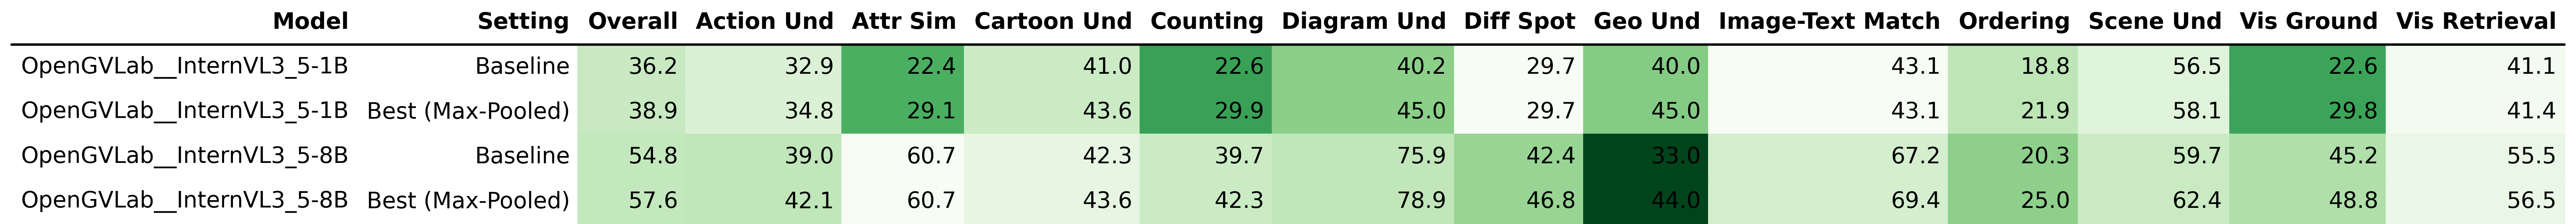

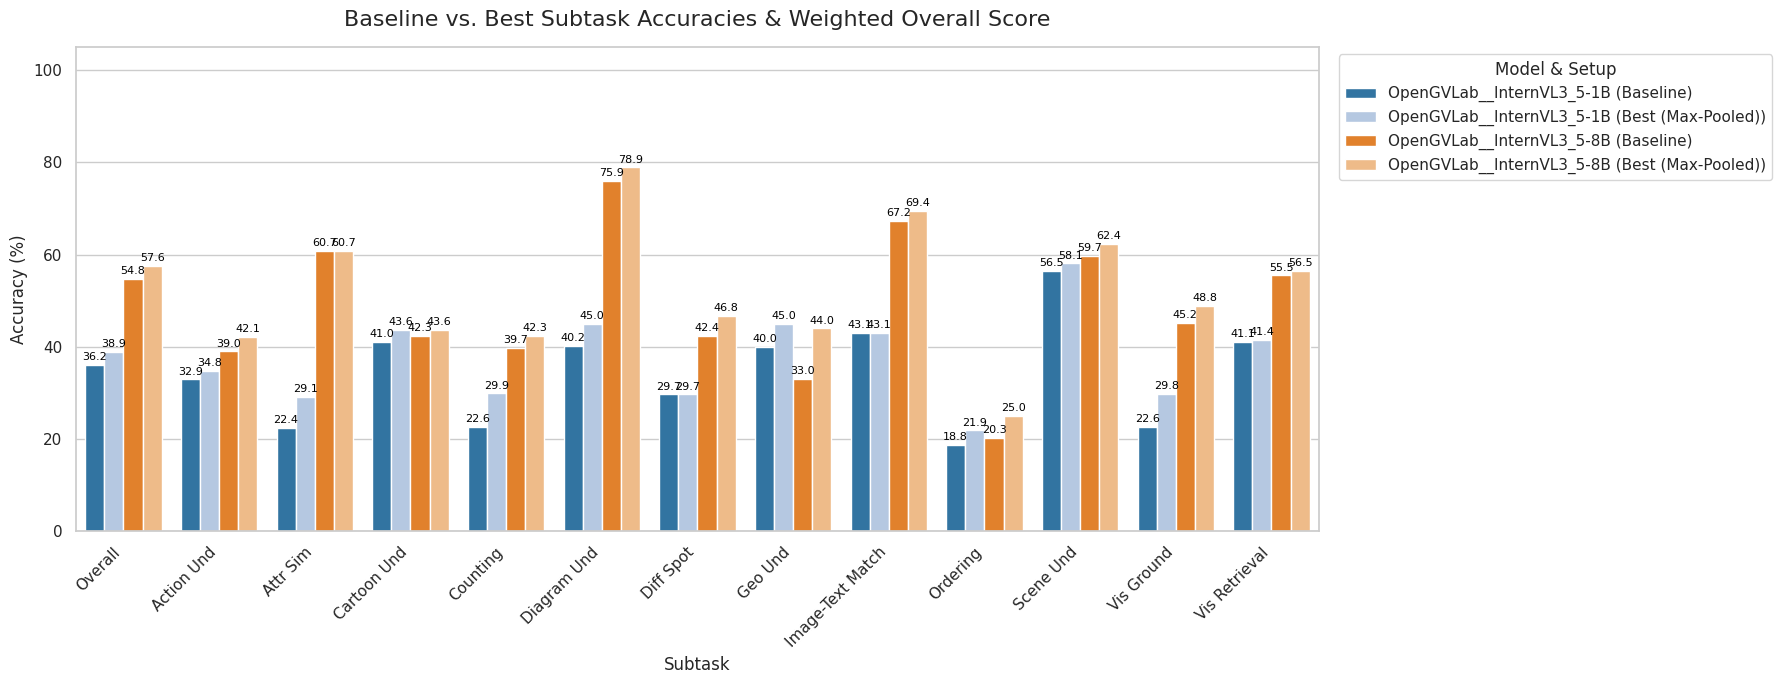

In [19]:
import io
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from IPython.display import Image, display

# ==========================================
# CUSTOMIZATION: Shorten Subtask Names
# ==========================================
SUBTASK_NAME_MAP = {
    "Scene Understanding": "Scene Und",
    "Spatial Relation": "Spatial",
    "Object Recognition": "Object Recog",
    "Document Understanding": "Doc Und",
    "Action Understanding": "Action Und",
    "Attribute Similarity": "Attr Sim",
    "Cartoon Understanding": "Cartoon Und",
    "Diagram Understanding": "Diagram Und",
    "Difference Spotting": "Diff Spot",
    "Geographic Understanding": "Geo Und",
    "Image-Text Matching": "Image-Text Match",
    "Visual Grounding": "Vis Ground",
    "Visual Retrieval": "Vis Retrieval",
}

def simplify_model_name(name):
    """Simplifies the raw model name from the logs to a cleaner format."""
    # name_lower = str(name).lower()
    # if '3b' in name_lower:
    #     return 'Qwen2.5vl-3b'
    # elif '7b' in name_lower:
    #     return 'Qwen2.5vl-7b'
    return name

# Assume muir_rows is already generated from your log parsing loop
df = pd.DataFrame(muir_rows)
# drop the rows where the model name is "OpenGVLab__InternVL3-1B","OpenGVLab__InternVL3-8B"
df = df[~df['Model'].isin(["OpenGVLab__InternVL3-1B","OpenGVLab__InternVL3-8B"])]


if not df.empty:
    # 0. Simplify Model Names
    df['Model'] = df['Model'].apply(simplify_model_name)
    
    # 0.5 Rename Subtasks (both the accuracy columns and their hidden _count columns)
    rename_dict = {}
    for old_name, short_name in SUBTASK_NAME_MAP.items():
        # Only add to dict if the column actually exists in the data
        if old_name in df.columns:
            rename_dict[old_name] = short_name
        if f"{old_name}_count" in df.columns:
            rename_dict[f"{old_name}_count"] = f"{short_name}_count"
            
    df = df.rename(columns=rename_dict)

    # 1. Identify subtasks and their corresponding count columns
    all_cols = df.columns.tolist()
    count_cols = [c for c in all_cols if c.endswith('_count')]
    subtasks = [c.replace('_count', '') for c in count_cols]
    
    # 2. Extract the Baseline results
    baseline_df = df[df['Masked Layers'].astype(str).str.lower() == 'baseline'].copy()
    baseline_df['Setting'] = 'Baseline'
    
    # 3. Calculate the Best (Max-Pooled) results
    best_df = df.groupby('Model')[subtasks].max().reset_index()
    best_df['Setting'] = 'Best (Max-Pooled)'
    
    # 4. Calculate the TRUE Weighted 'Overall' for the Best setup
    task_counts = df.groupby('Model')[count_cols].first().reset_index()
    task_counts['total_instances'] = task_counts[count_cols].sum(axis=1)
    
    for model in best_df['Model'].unique():
        model_best_idx = best_df.index[best_df['Model'] == model].tolist()[0]
        model_count_idx = task_counts.index[task_counts['Model'] == model].tolist()[0]
        
        total_correct_theoretical = 0
        for task in subtasks:
            acc = best_df.at[model_best_idx, task]
            count = task_counts.at[model_count_idx, f"{task}_count"]
            total_correct_theoretical += (acc / 100.0) * count
            
        total_instances = task_counts.at[model_count_idx, 'total_instances']
        best_df.at[model_best_idx, 'Overall'] = (total_correct_theoretical / total_instances) * 100

    # 5. Combine Baseline and Best DataFrames
    combined_df = pd.concat([
        baseline_df[['Model', 'Setting', 'Overall'] + sorted(subtasks)],
        best_df[['Model', 'Setting', 'Overall'] + sorted(subtasks)]
    ], ignore_index=True)

    combined_df = combined_df.sort_values(by=['Model', 'Setting']).reset_index(drop=True)
    metrics = ['Overall'] + sorted(subtasks)

    # ==========================================
    # CALCULATE DIFFERENCES FOR COLOR HIGHLIGHTING
    # ==========================================
    # Create a dataframe of the same shape to hold the gradient values (deltas)
    gmap_df = pd.DataFrame(0.0, index=combined_df.index, columns=metrics)

    for model in combined_df['Model'].unique():
        baseline_mask = (combined_df['Model'] == model) & (combined_df['Setting'] == 'Baseline')
        best_mask = (combined_df['Model'] == model) & (combined_df['Setting'] == 'Best (Max-Pooled)')
        
        if baseline_mask.any() and best_mask.any():
            idx_base = combined_df[baseline_mask].index[0]
            idx_best = combined_df[best_mask].index[0]
            
            # Calculate the improvement difference (Best - Baseline)
            for col in metrics:
                delta = combined_df.at[idx_best, col] - combined_df.at[idx_base, col]
                # Apply delta to both rows so the pair is highlighted based on improvement
                gmap_df.at[idx_base, col] = delta
                gmap_df.at[idx_best, col] = delta

    # ==========================================
    # DISPLAY TABLE AS IMAGE
    # ==========================================
    print("\n### Baseline vs. Best MuirBench Results (Highlighted by Improvement)")

    styled_table = (
        combined_df.style.format(precision=1, na_rep="-")
        .hide(axis="index")  
        # Added axis=None here to fix the DataFrame gmap error!
        .background_gradient(cmap='Greens', subset=metrics, gmap=gmap_df, axis=None)
        .set_properties(subset=['Model', 'Setting'], 
                        **{'background-color': '#ffffff', 'color': '#000000', 'font-weight': 'bold'})
        .set_properties(subset=metrics, 
                        **{'text-align': 'center', 'border': '1px solid black', 'color': '#000000'})
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('font-size', '12pt'), 
                ('text-align', 'center'), 
                ('background-color', '#e6e6e6'), 
                ('color', '#000000'), 
                ('border', '1px solid black')
            ]},
            {'selector': 'td', 'props': [
                ('font-size', '11pt'), 
                ('border', '1px solid black')
            ]}
        ])
    )

    buf = io.BytesIO()
    try:
        dfi.export(styled_table, buf, table_conversion='matplotlib', dpi=300)
        display(Image(data=buf.getvalue(), format='png'))
    except Exception as e:
        print(f"\nCould not render image. Error: {e}")
        print("Falling back to standard HTML display:")
        display(styled_table)

    # ==========================================
    # VISUALIZATION (BAR CHART)
    # ==========================================
    combined_df['Model_Setting'] = combined_df['Model'] + " (" + combined_df['Setting'] + ")"

    melted_df = combined_df.melt(
        id_vars=['Model', 'Setting', 'Model_Setting'], 
        value_vars=metrics, 
        var_name='Task', 
        value_name='Accuracy'
    )

    plt.figure(figsize=(18, 7))
    sns.set_theme(style="whitegrid")

    ax = sns.barplot(
        data=melted_df, 
        x='Task', 
        y='Accuracy', 
        hue='Model_Setting',
        palette='tab20'
    )

    plt.title('Baseline vs. Best Subtask Accuracies & Weighted Overall Score', fontsize=16, pad=15)
    plt.xlabel('Subtask', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    
    # Kept rotation at 45 because 14 items across the X-axis can get crowded
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.ylim(0, 105) 
    
    plt.legend(title='Model & Setup', bbox_to_anchor=(1.01, 1), loc='upper left')

    for p in ax.patches:
        height = p.get_height()
        if pd.notnull(height) and height > 0:
            ax.annotate(f'{height:.1f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', 
                        fontsize=8, color='black', xytext=(0, 2), 
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

else:
    print("No data available to process.")


### Baseline vs. Ceiling MuirBench Results (Highlighted by Improvement)


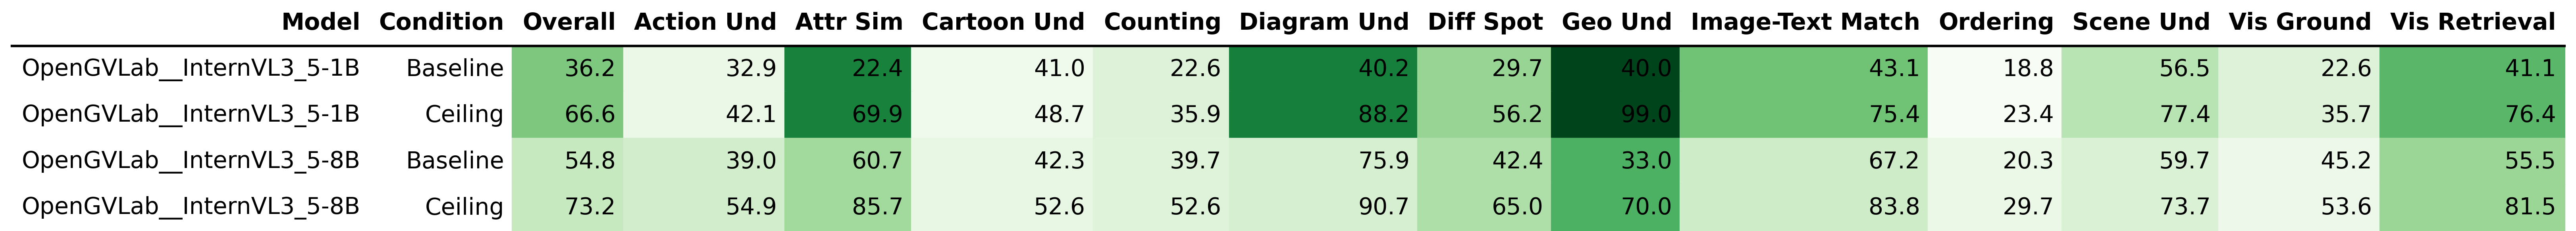

In [12]:
import io
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from IPython.display import Image, display

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multi-image/lmms-eval/logs/masked"
BASELINE_LOG_DIRECTORIES = "/lustre/groups/eml/projects/bravom/scripts/multi-image/lmms-eval/logs/baseline"

SUBTASK_NAME_MAP = {
    "Scene Understanding": "Scene Und",
    "Spatial Relation": "Spatial",
    "Object Recognition": "Object Recog",
    "Document Understanding": "Doc Und",
    "Action Understanding": "Action Und",
    "Attribute Similarity": "Attr Sim",
    "Cartoon Understanding": "Cartoon Und",
    "Diagram Understanding": "Diagram Und",
    "Difference Spotting": "Diff Spot",
    "Geographic Understanding": "Geo Und",
    "Image-Text Matching": "Image-Text Match",
    "Visual Grounding": "Vis Ground",
    "Visual Retrieval": "Vis Retrieval",
}

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def normalize_val(val):
    s = str(val).strip().lower()
    try:
        f_val = float(s)
        if f_val.is_integer(): return str(int(f_val))
    except: pass
    return s

def calculate_acc(correct, total):
    return (correct / total * 100) if total > 0 else 0.0

def simplify_model_name(name):
    name_lower = str(name).lower()
    if '1b' in name_lower: return 'InternVL3.5-1B'
    elif '7b' in name_lower: return 'InternVL3.5-7B'
    return name

# ==========================================
# 3. DATA PARSING (Sample-Level Logic)
# ==========================================

baseline_stats = {}
ceiling_stats = {}

# Glob both the masked (ceiling) logs and the baseline logs
masked_files = glob.glob(os.path.join(LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)
baseline_files = glob.glob(os.path.join(BASELINE_LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)

all_results_files = masked_files + baseline_files

for res_file in all_results_files:
    dir_name = os.path.dirname(res_file)
    base_name = os.path.basename(res_file).replace('_results.json', '')
    
    try:
        with open(res_file, 'r') as f:
            meta = json.load(f)
            model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
    except: continue
        
    muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
    
    if os.path.exists(muir_path):
        
        # Determine if it's a baseline based on the file path
        is_baseline = res_file in baseline_files
        
        if model_name not in ceiling_stats: ceiling_stats[model_name] = {}
        if model_name not in baseline_stats: baseline_stats[model_name] = {}
            
        try:
            with open(muir_path, 'r') as f:
                for line in f:
                    entry = json.loads(line)
                    info = entry.get('muirbench_score_overall', {})
                    if not info: continue
                    
                    doc_id = entry.get('doc_id', info.get('idx'))
                    task = info.get('task', 'Unknown')
                    pred = normalize_val(info.get('pred', ''))
                    ans  = normalize_val(info.get('answer', ''))
                    is_correct = (pred == ans)
                    
                    if is_baseline:
                        # Track Baseline
                        if task not in baseline_stats[model_name]: baseline_stats[model_name][task] = {}
                        baseline_stats[model_name][task][doc_id] = is_correct
                    else:
                        # Track Ceiling
                        if task not in ceiling_stats[model_name]: ceiling_stats[model_name][task] = {}
                        ceiling_stats[model_name][task][doc_id] = ceiling_stats[model_name][task].get(doc_id, False) or is_correct

        except: continue

final_rows = []

for model_name in ceiling_stats.keys():
    # Baseline
    if model_name in baseline_stats and baseline_stats[model_name]:
        base_row = {'Model': model_name, 'Condition': 'Baseline'}
        tc_base, tot_base = 0, 0
        for task, docs in baseline_stats[model_name].items():
            task_total = len(docs)
            task_correct = sum(docs.values())
            base_row[task] = calculate_acc(task_correct, task_total)
            tot_base += task_total
            tc_base += task_correct
        base_row['Overall'] = calculate_acc(tc_base, tot_base)
        final_rows.append(base_row)
        
    # Ceiling
    ceil_row = {'Model': model_name, 'Condition': 'Ceiling'}
    tc_ceil, tot_ceil = 0, 0
    for task, docs in ceiling_stats[model_name].items():
        task_total = len(docs)
        task_correct = sum(docs.values())
        ceil_row[task] = calculate_acc(task_correct, task_total)
        tot_ceil += task_total
        tc_ceil += task_correct
    ceil_row['Overall'] = calculate_acc(tc_ceil, tot_ceil)
    final_rows.append(ceil_row)

# ==========================================
# 4. FORMATTING & VISUALIZATION
# ==========================================

df = pd.DataFrame(final_rows)

if not df.empty:
    # Cleanup Names
    # df['Model'] = df['Model'].apply(simplify_model_name)
    df = df.rename(columns=SUBTASK_NAME_MAP)
    # drop the row with model name as InternVL3-1B or InternVL3-8B
    df = df[~df['Model'].isin(["OpenGVLab__InternVL3-1B", "OpenGVLab__InternVL3-8B"])]
    # Sort Columns
    meta = ['Model', 'Condition']
    metrics = [c for c in df.columns if c not in meta]
    if 'Overall' in metrics:
        metrics.remove('Overall')
        metrics = ['Overall'] + sorted(metrics)
    else:
        metrics = sorted(metrics)
        
    df = df[meta + metrics]
    df = df.sort_values(by=['Model', 'Condition']).reset_index(drop=True)

    # Calculate Deltas for Color Map
    gmap_df = pd.DataFrame(0.0, index=df.index, columns=metrics)
    for model in df['Model'].unique():
        baseline_mask = (df['Model'] == model) & (df['Condition'] == 'Baseline')
        ceiling_mask = (df['Model'] == model) & (df['Condition'] == 'Ceiling')
        
        if baseline_mask.any() and ceiling_mask.any():
            idx_base = df[baseline_mask].index[0]
            idx_ceil = df[ceiling_mask].index[0]
            
            for col in metrics:
                delta = df.at[idx_ceil, col] - df.at[idx_base, col]
                gmap_df.at[idx_base, col] = delta
                gmap_df.at[idx_ceil, col] = delta

    # Render Table as Image
    print("\n### Baseline vs. Ceiling MuirBench Results (Highlighted by Improvement)")

    styled_table = (
        df.style.format(precision=1, na_rep="-")
        .hide(axis="index")  
        .background_gradient(cmap='Greens', subset=metrics, gmap=gmap_df, axis=None)
        .set_properties(subset=['Model', 'Condition'], 
                        **{'background-color': '#ffffff', 'color': '#000000', 'font-weight': 'bold'})
        .set_properties(subset=metrics, 
                        **{'text-align': 'center', 'border': '1px solid black', 'color': '#000000'})
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('font-size', '12pt'), 
                ('text-align', 'center'), 
                ('background-color', '#e6e6e6'), 
                ('color', '#000000'), 
                ('border', '1px solid black')
            ]},
            {'selector': 'td', 'props': [
                ('font-size', '11pt'), 
                ('border', '1px solid black')
            ]}
        ])
    )

    buf = io.BytesIO()
    try:
        dfi.export(styled_table, buf, table_conversion='matplotlib', dpi=300)
        display(Image(data=buf.getvalue(), format='png'))
    except Exception as e:
        print(f"\nCould not render image. Error: {e}")
        display(styled_table)

else:
    print("No data available to process.")